# 🚗 Fuel Efficiency Prediction using Machine Learning

This notebook demonstrates a machine learning workflow to predict a vehicle's fuel efficiency (`mpg`) using the Auto MPG dataset. It includes:

- 🔹 Data preprocessing and imputation
- 🔹 Outlier detection and removal
- 🔹 Exploratory data analysis and visualizations
- 🔹 Regression modeling using:
  - Linear Regression
  - Ridge & Lasso Regression
  - Random Forest Regressor
- 🔹 Hyperparameter tuning with GridSearchCV
- 🔹 Evaluation with RMSE, MSE, and R²
- 🔹 K-Fold Cross-validation

📁 *For full project overview, see the [README.md](./README.md)*


## Installation

We recommend setting up a fresh Python 3.10+ environment and installing dependencies with:

```bash
pip install -r requirements.txt


In [11]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from pathlib import Path

In [15]:
# Load dataset
df = pd.read_csv("auto-mpg.csv")

# Display top rows
print("\n🔹 Sample Data:")
display(df.head())

# Data types
print("\n🔹 Column Data Types:")
print(df.dtypes)

# Dimensions
print(f"\n🔹 Dataset Dimensions: {df.shape[0]} rows × {df.shape[1]} columns")

# Summary stats
print("\n🔹 Summary Statistics:")
display(df.describe(include='all'))

# Dataset info
print("\n🔹 Dataset Info:")
df.info()

# Duplicate check
print("\n🔹 Duplicate Rows (if any):")
duplicates = df[df.duplicated()]
display(duplicates)

# Count and remove duplicates
duplicate_count = df.duplicated().sum()
print(f"\nFound {duplicate_count} duplicate rows. Removing them...")
df = df.drop_duplicates()
print(f"✅ Remaining rows after deduplication: {df.shape[0]}")



🔹 Sample Data:


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino



🔹 Column Data Types:
mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight            int64
acceleration    float64
model year        int64
origin            int64
car name         object
dtype: object

🔹 Dataset Dimensions: 398 rows × 9 columns

🔹 Summary Statistics:


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
count,398.000000,398.000000,398.000000,398,398.000000,398.000000,398.000000,398.000000,398
unique,NaN,NaN,NaN,94,NaN,NaN,NaN,NaN,305
top,NaN,NaN,NaN,150,NaN,NaN,NaN,NaN,ford pinto
freq,NaN,NaN,NaN,22,NaN,NaN,NaN,NaN,6
mean,23.514573,5.454774,193.425879,NaN,2970.424623,15.568090,76.010050,1.572864,NaN
std,7.815984,1.701004,104.269838,NaN,846.841774,2.757689,3.697627,0.802055,NaN
min,9.000000,3.000000,68.000000,NaN,1613.000000,8.000000,70.000000,1.000000,NaN
25%,17.500000,4.000000,104.250000,NaN,2223.750000,13.825000,73.000000,1.000000,NaN
50%,23.000000,4.000000,148.500000,NaN,2803.500000,15.500000,76.000000,1.000000,NaN
75%,29.000000,8.000000,262.000000,NaN,3608.000000,17.175000,79.000000,2.000000,NaN



🔹 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB

🔹 Duplicate Rows (if any):


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name



Found 0 duplicate rows. Removing them...
✅ Remaining rows after deduplication: 398


In [19]:
# 🔍 Check for missing values in the entire dataset
missing_summary = df.isna().sum()

# Filter only columns with missing values
missing_summary = missing_summary[missing_summary > 0]

if missing_summary.empty:
    print("✅ No missing values found in the dataset.")
else:
    print("⚠️ Columns with missing values:")
    display(missing_summary.sort_values(ascending=False))


✅ No missing values found in the dataset.


In [17]:
# Fix non-numeric entries in 'horsepower'
df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')

# Check how many are missing
missing_count = df['horsepower'].isna().sum()
print(f"\nMissing values in 'horsepower': {missing_count}")

# Compute skewness (excluding NaNs)
skewness = df['horsepower'].dropna().skew()
print(f"Skewness of 'horsepower': {skewness:.3f}")

# Fill missing values based on skewness
if abs(skewness) < 0.5:
    df['horsepower'] = df['horsepower'].fillna(df['horsepower'].mean())
    print("Filled missing horsepower values with mean (approximately normal distribution).")
else:
    df['horsepower'] = df['horsepower'].fillna(df['horsepower'].median())
    print("Filled missing horsepower values with median (skewed distribution).")



Missing values in 'horsepower': 6
Skewness of 'horsepower': 1.087
Filled missing horsepower values with median (skewed distribution).


In [21]:
# Function to remove outliers using the IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Columns to clean
target_cols = ['mpg', 'displacement', 'horsepower', 'weight', 'acceleration']

# Remove outliers (horsepower must be already numeric & imputed)
for col in target_cols:
    df = remove_outliers(df, col)

print(f"✅ Dataset shape after outlier removal: {df.shape}")


✅ Dataset shape after outlier removal: (378, 9)


In [23]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Select numeric columns (excluding target 'mpg' if you don't want to scale it)
numerical_columns = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year']

# Standard Scaling (Z-score)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[numerical_columns])
df_scaled = pd.DataFrame(scaled_data, columns=[f"{col}_scaled" for col in numerical_columns])

# Min-Max Normalization
normalizer = MinMaxScaler()
normalized_data = normalizer.fit_transform(df[numerical_columns])
df_normalized = pd.DataFrame(normalized_data, columns=[f"{col}_normalized" for col in numerical_columns])

# Add scaled and normalized data to original dataframe
df = pd.concat([df.reset_index(drop=True), df_scaled, df_normalized], axis=1)

# Show preview
df.head()


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,cylinders_scaled,...,horsepower_scaled,weight_scaled,acceleration_scaled,model year_scaled,cylinders_normalized,displacement_normalized,horsepower_normalized,weight_normalized,acceleration_normalized,model year_normalized
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu,1.574815,...,0.865510,0.692976,-1.473620,-1.698075,1.0,0.662050,0.552632,0.536150,0.198413,0.0
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320,1.574815,...,1.926055,0.922856,-1.678079,-1.698075,1.0,0.781163,0.782895,0.589736,0.158730,0.0
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite,1.574815,...,1.471536,0.610268,-1.882538,-1.698075,1.0,0.692521,0.684211,0.516870,0.119048,0.0
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst,1.574815,...,1.471536,0.606619,-1.473620,-1.698075,1.0,0.653740,0.684211,0.516019,0.198413,0.0
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino,1.574815,...,1.168523,0.626080,-2.086997,-1.698075,1.0,0.648199,0.618421,0.520556,0.079365,0.0


In [31]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Define feature lists
numerical_features = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year']
categorical_features = ['origin']

# Target column
target = 'mpg'

# Drop rows with missing target
df = df.dropna(subset=[target])

# Split data
X = df[numerical_features + categorical_features]
y = df[target]

# Define preprocessing for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [57]:
# Build full pipeline with Linear Regression
model_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', LinearRegression())
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline
model_pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = model_pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"✅ Linear Regression Results: RMSE = {mse ** 0.5:.2f}, R² = {r2:.2f}")


✅ Linear Regression Results: RMSE = 3.66, R² = 0.82


In [33]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔍 Show dataset shapes
print(f"Training set shape: X = {X_train.shape}, y = {y_train.shape}")
print(f"Testing set shape:  X = {X_test.shape}, y = {y_test.shape}")


Training set shape: X = (302, 7), y = (302,)
Testing set shape:  X = (76, 7), y = (76,)



🔍 Generating Pair Plot of important numeric features...


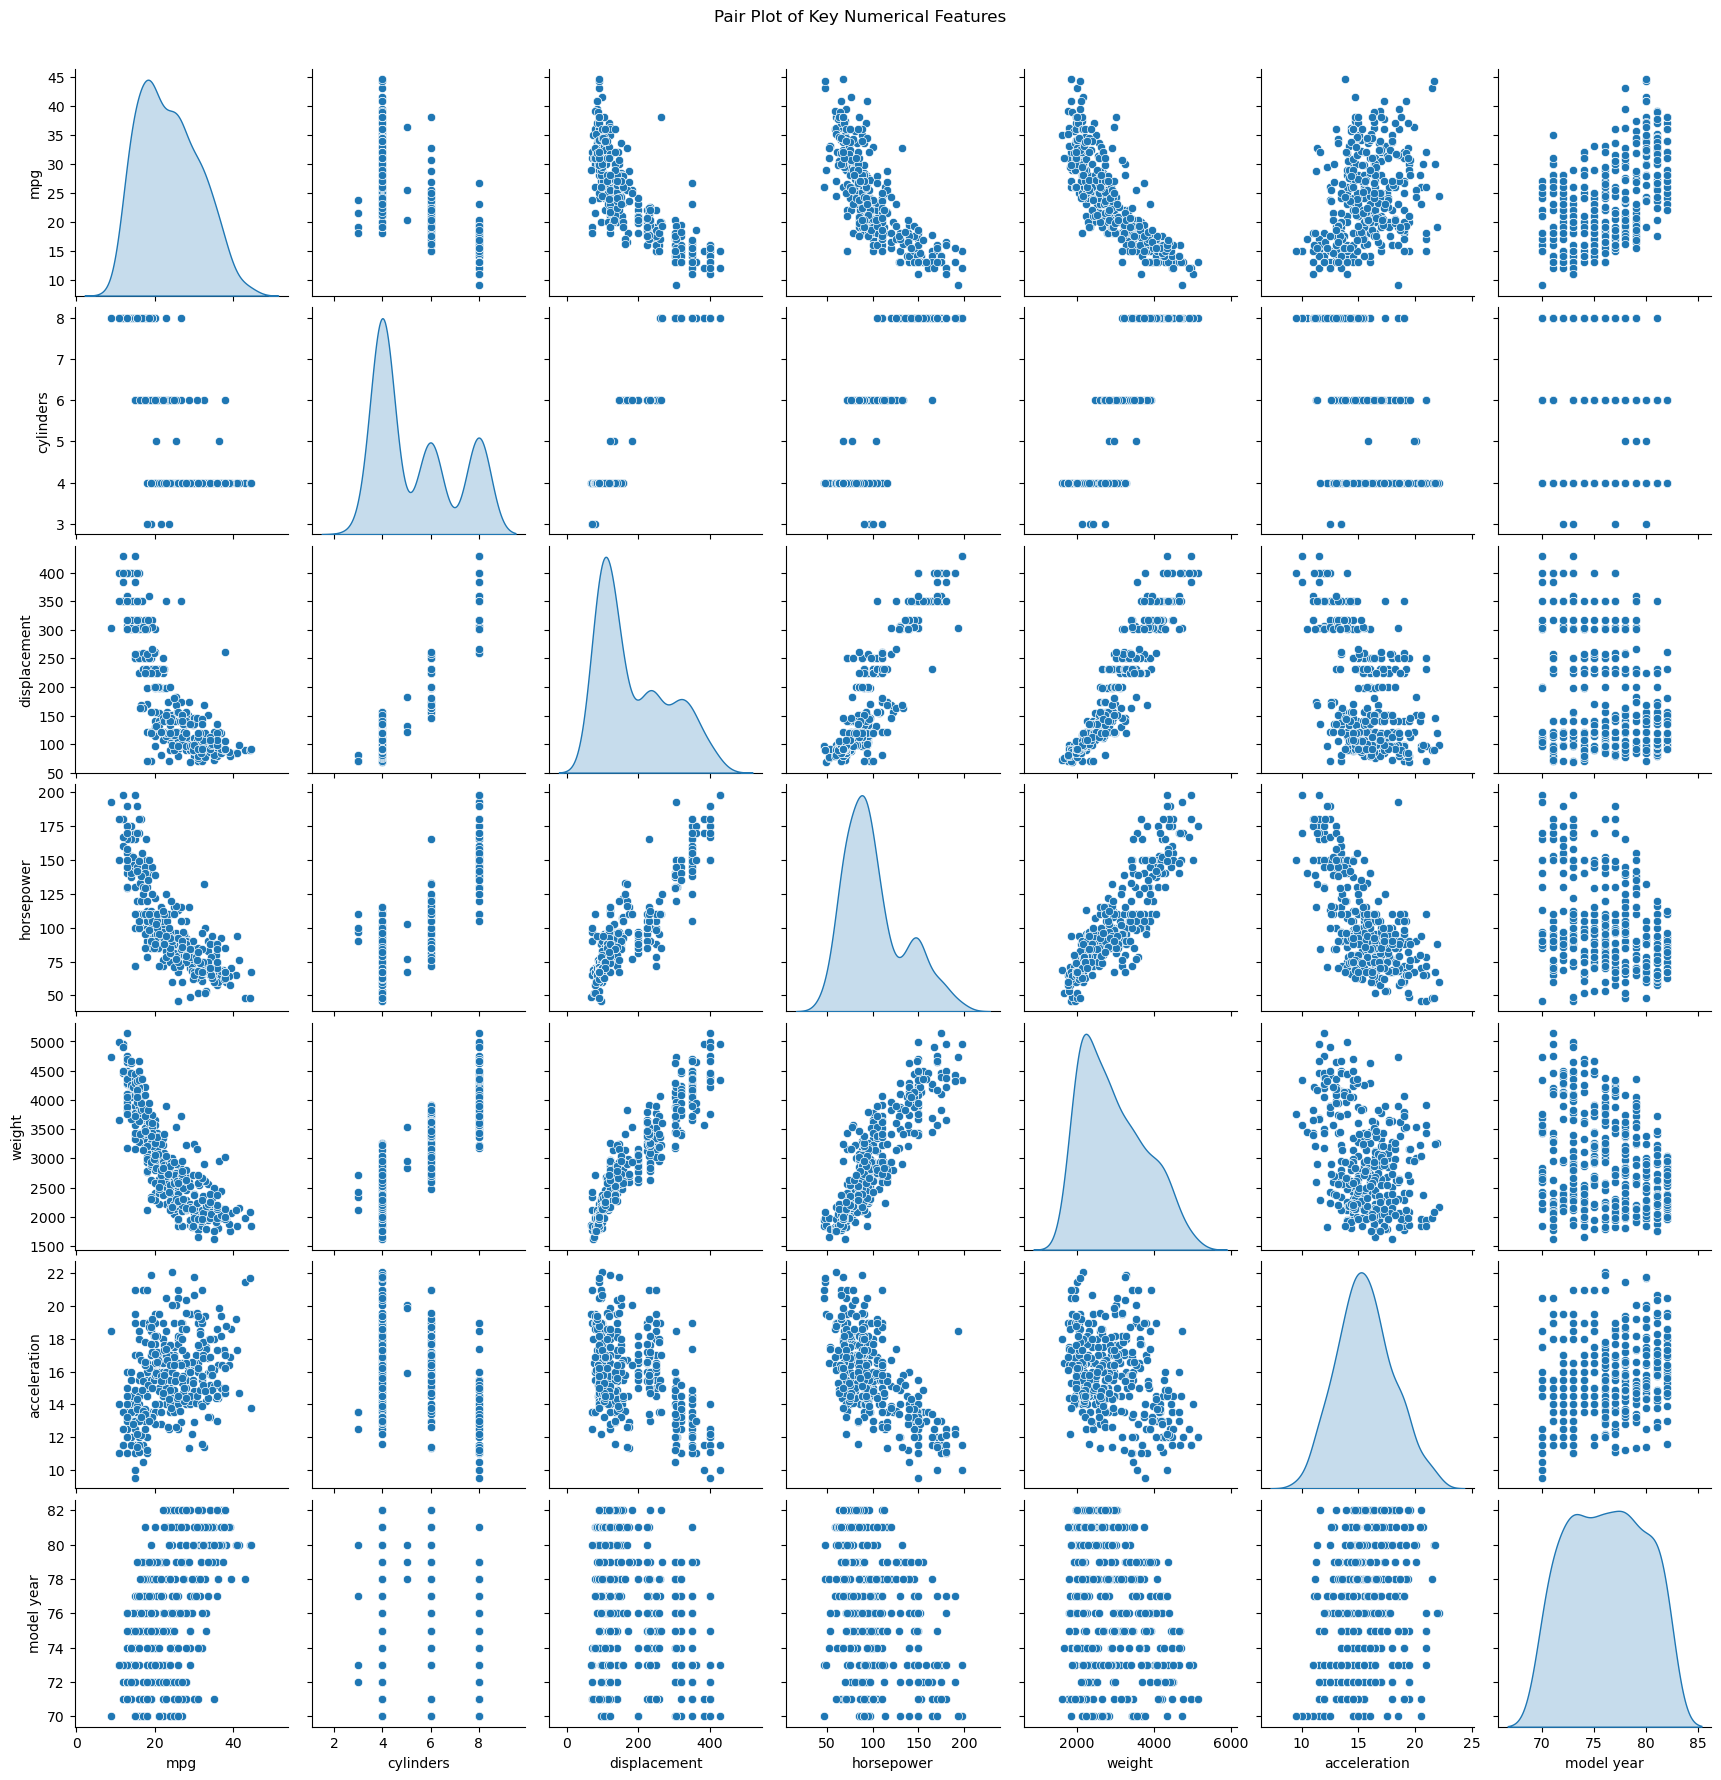

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define relevant numerical features for visualization
important_features = [
    'mpg', 'cylinders', 'displacement', 'horsepower', 
    'weight', 'acceleration', 'model year'
]

# Filter only valid features (in case of renames/missing)
valid_features = [feature for feature in important_features if feature in df.columns]

# Generate Pair Plot
print("\n🔍 Generating Pair Plot of important numeric features...")
sns.pairplot(df[valid_features], diag_kind='kde', height=2.5)
plt.suptitle("Pair Plot of Key Numerical Features", y=1.02)
plt.show()


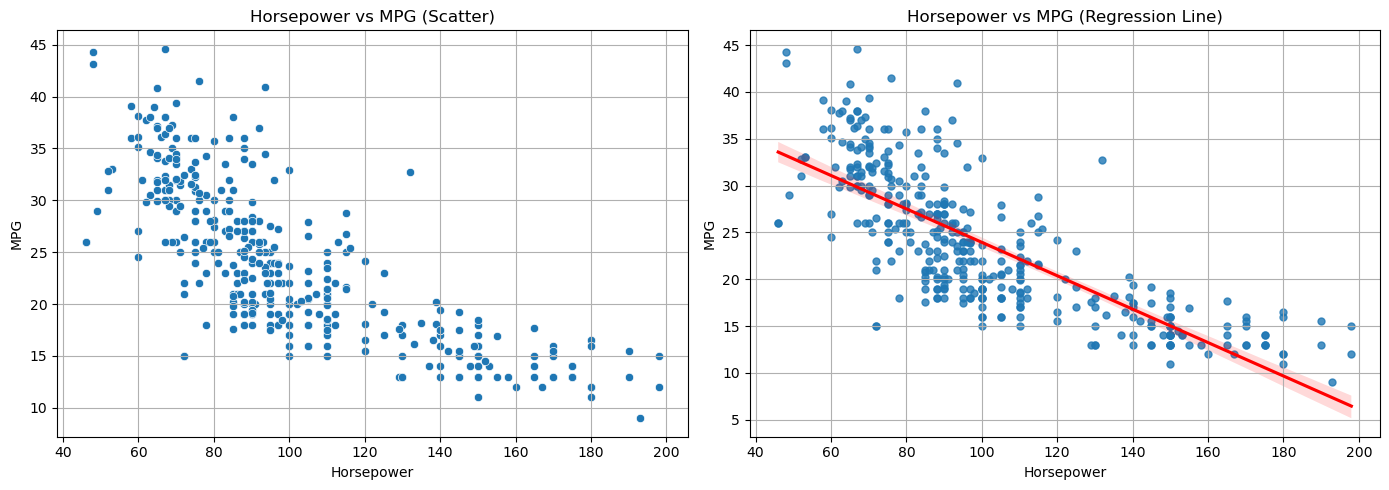

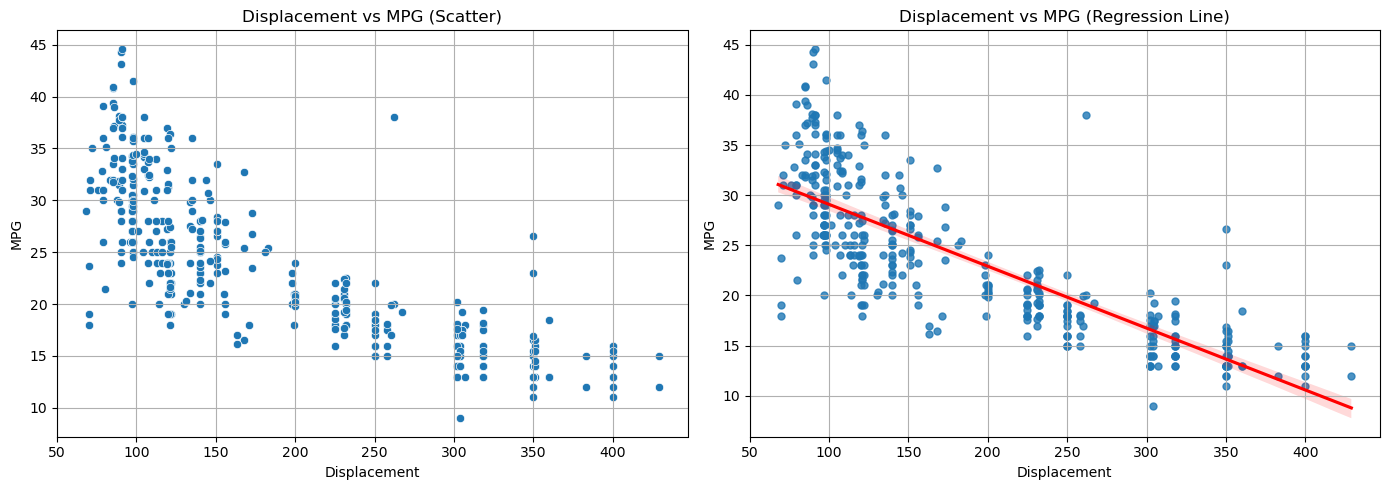

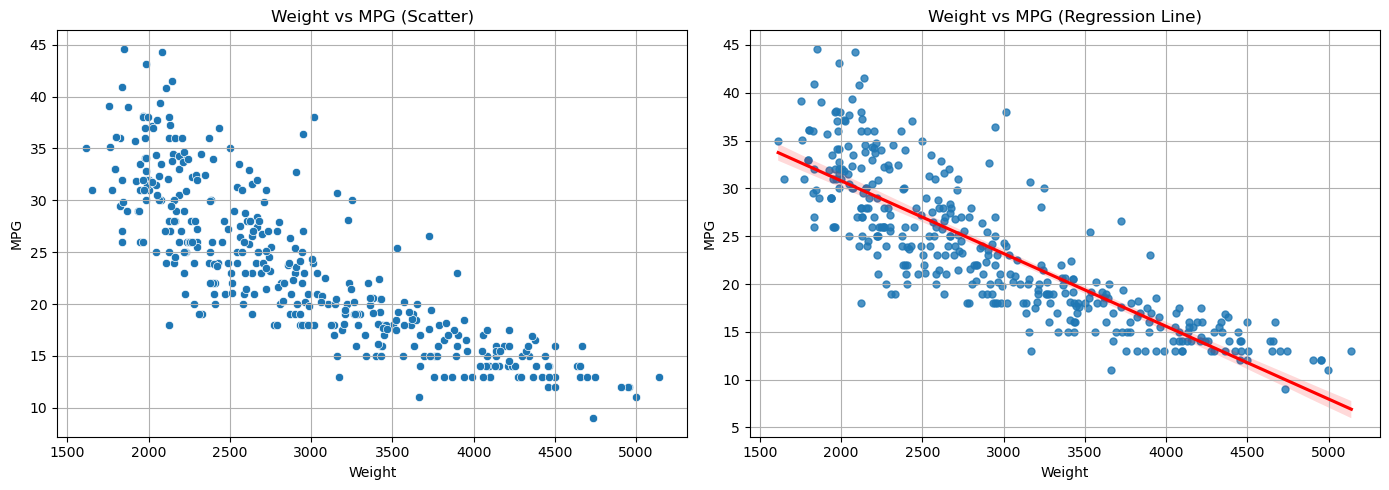

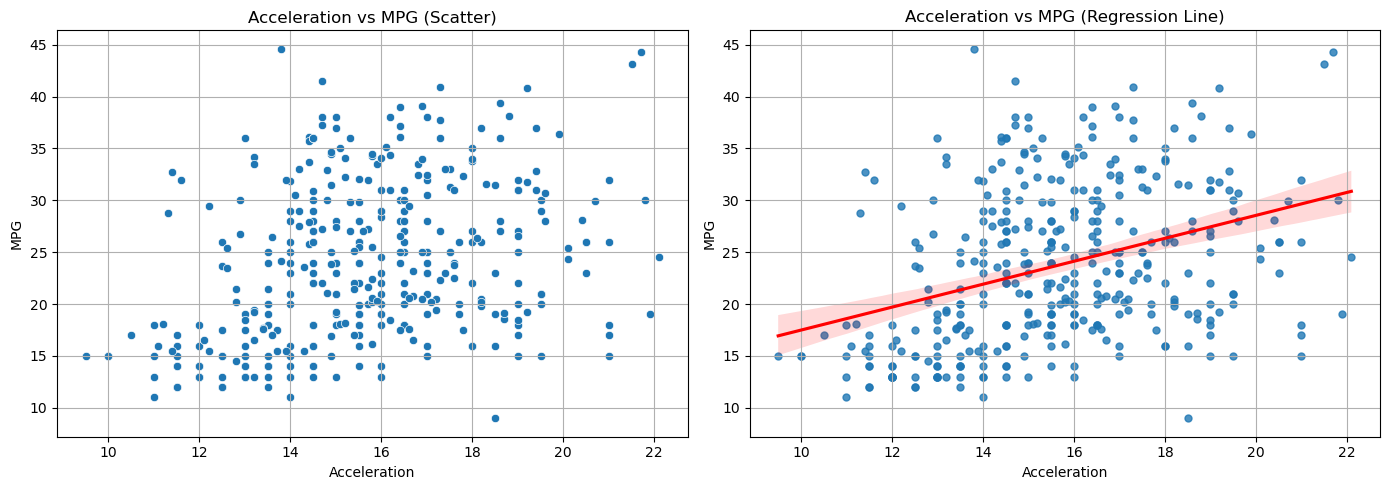

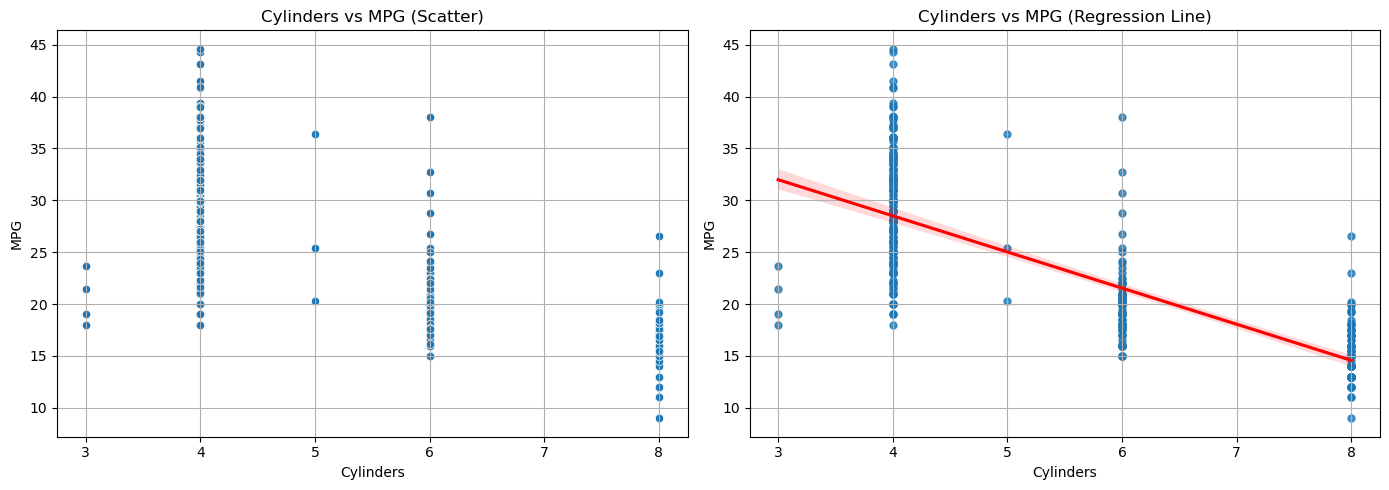

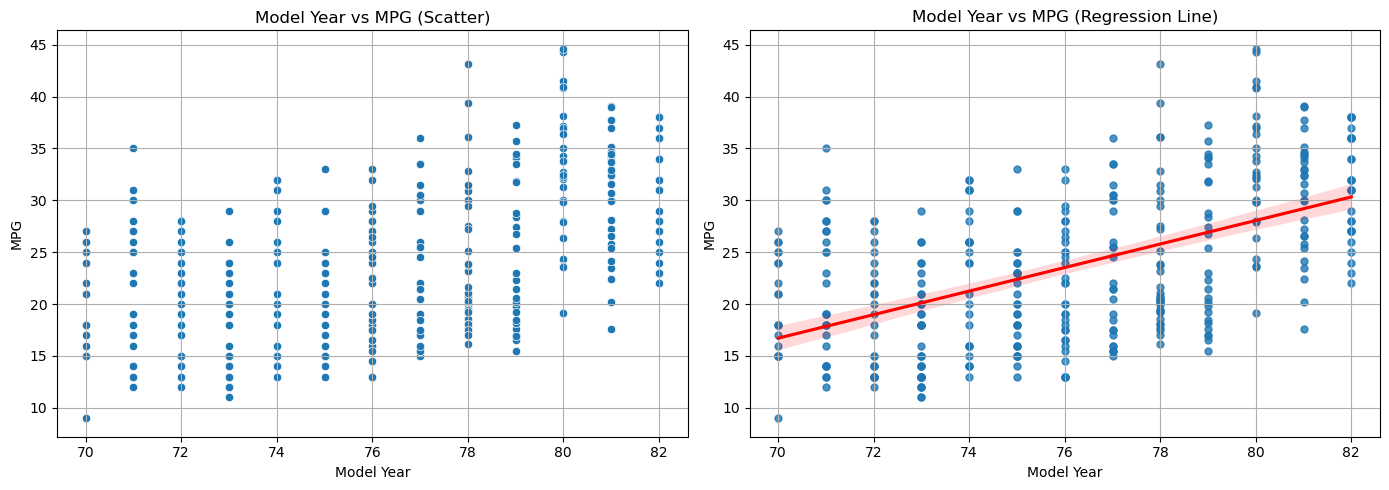

In [53]:
# Ensure horsepower is numeric
df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')
df = df.dropna(subset=['horsepower'])

# Feature list
features = ['horsepower', 'displacement', 'weight', 'acceleration', 'cylinders', 'model year']

# Loop to create 2 plots per feature
for feature in features:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Scatter plot
    sns.scatterplot(x=feature, y='mpg', data=df, ax=axes[0])
    axes[0].set_title(f"{feature.title()} vs MPG (Scatter)")
    axes[0].set_xlabel(feature.title())
    axes[0].set_ylabel("MPG")
    axes[0].grid(True)

    # Regression plot
    sns.regplot(x=feature, y='mpg', data=df, ax=axes[1], scatter_kws={"s": 25}, line_kws={"color": "red"})
    axes[1].set_title(f"{feature.title()} vs MPG (Regression Line)")
    axes[1].set_xlabel(feature.title())
    axes[1].set_ylabel("MPG")
    axes[1].grid(True)

    # Layout
    plt.tight_layout()
    plt.show()


In [63]:
from sklearn.ensemble import RandomForestRegressor

# Ensure 'horsepower' is numeric and drop any missing
df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')
df = df.dropna(subset=['horsepower', 'mpg'])  # Drop rows where target or features are missing

# Define target and features
target = 'mpg'
X = df.drop(columns=['mpg', 'car name'])  # drop target and text column
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest pipeline with imputation only (no scaling needed for tree models)
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Define hyperparameter grid
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['sqrt', 'log2']
}

# Grid Search with 5-fold CV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

# Fit and evaluate
grid_search.fit(X_train, y_train)
print("\n✅ Best Hyperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n📊 Random Forest Performance:")
print(f"   - MSE: {mse:.2f}")
print(f"   - R²: {r2:.3f}")


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


C:\Users\visha\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



✅ Best Hyperparameters: {'regressor__max_depth': None, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 100}

📊 Random Forest Performance:
   - MSE: 7.82
   - R²: 0.896


In [65]:
# Ensure 'horsepower' is numeric
df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')

# Drop rows with missing target or feature values
df = df.dropna(subset=['horsepower', 'mpg'])

# Define features and target
X = df.drop(columns=['mpg', 'car name'])  # Remove target and text column
y = df['mpg']

#  Impute missing values (in case there are any left)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

#  Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Train Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predict
y_pred_linear = linear_model.predict(X_test)

# Evaluate
linear_mse = mean_squared_error(y_test, y_pred_linear)
linear_rmse = np.sqrt(linear_mse)
linear_r2 = r2_score(y_test, y_pred_linear)

# Display results
print("✅ Linear Regression Results:")
print(f"   - Root Mean Squared Error (RMSE): {linear_rmse:.2f}")
print(f"   - Mean Squared Error (MSE): {linear_mse:.2f}")
print(f"   - R² Score: {linear_r2:.3f}")

✅ Linear Regression Results:
   - Root Mean Squared Error (RMSE): 3.70
   - Mean Squared Error (MSE): 13.66
   - R² Score: 0.818


In [67]:
# Fit Lasso Regression model
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

# Predict
y_pred_lasso = lasso.predict(X_test)

#  Evaluation
mse = mean_squared_error(y_test, y_pred_lasso)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_lasso)

print("\n✅ Lasso Regression Results:")
print(f"   - MSE: {mse:.2f}")
print(f"   - RMSE: {rmse:.2f}")
print(f"   - R-squared: {r2:.2f}")
print(f"   - Coefficients: {[f'{coef:.2f}' for coef in lasso.coef_]}")


✅ Lasso Regression Results:
   - MSE: 13.69
   - RMSE: 3.70
   - R-squared: 0.82
   - Coefficients: ['-0.00', '0.01', '-0.04', '-0.01', '-0.00', '0.73', '0.82', '-0.00', '0.00', '-0.00', '-0.00', '-0.00', '0.00', '-0.00', '0.00', '-0.00', '-0.00', '-0.00', '0.00']


In [69]:
#Ridge regression with GridSearchCV
ridge = Ridge()
param_grid = {
    'alpha': [0.1, 1, 10, 100]
}

ridge_grid_search = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error'
)
ridge_grid_search.fit(X_train, y_train)

# Evaluate best model
best_ridge_model = ridge_grid_search.best_estimator_
y_pred_ridge = best_ridge_model.predict(X_test)

ridge_mse = mean_squared_error(y_test, y_pred_ridge)
ridge_rmse = np.sqrt(ridge_mse)
ridge_r2 = r2_score(y_test, y_pred_ridge)

# Print results
print("✅ Ridge Regression - Grid Search")
print(f"Best Alpha: {ridge_grid_search.best_params_['alpha']}")
print(f"MSE: {ridge_mse:.2f}, RMSE: {ridge_rmse:.2f}, R²: {ridge_r2:.2f}")

✅ Ridge Regression - Grid Search
Best Alpha: 10
MSE: 13.69, RMSE: 3.70, R²: 0.82


In [73]:
from sklearn.model_selection import KFold

# Define the K-Fold CV strategy
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define evaluation function
def evaluate_model(model, X, y, kf):
    mse_scores = []
    r2_scores = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        mse_scores.append(mean_squared_error(y_test, y_pred))
        r2_scores.append(r2_score(y_test, y_pred))
    
    return np.mean(mse_scores), np.std(mse_scores), np.mean(r2_scores), np.std(r2_scores)

# Run evaluation (assuming X_imputed and y are already defined)
linear_model = LinearRegression()
ridge_model = Ridge(alpha=1.0)

linear_mse_mean, linear_mse_std, linear_r2_mean, linear_r2_std = evaluate_model(linear_model, X_imputed, y.values, kf)
print(f"Linear Regression: MSE = {linear_mse_mean:.4f} ± {linear_mse_std:.4f}, R² = {linear_r2_mean:.4f} ± {linear_r2_std:.4f}")

ridge_mse_mean, ridge_mse_std, ridge_r2_mean, ridge_r2_std = evaluate_model(ridge_model, X_imputed, y.values, kf)
print(f"Ridge Regression: MSE = {ridge_mse_mean:.4f} ± {ridge_mse_std:.4f}, R² = {ridge_r2_mean:.4f} ± {ridge_r2_std:.4f}")

Linear Regression: MSE = 10.6377 ± 1.7274, R² = 0.8069 ± 0.0318
Ridge Regression: MSE = 10.6360 ± 1.7303, R² = 0.8070 ± 0.0317
